### Thermal Image Object Detection

In [1]:
import numpy as np 
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 
import csv
from skimage import color
from sklearn import svm


In [25]:
image_directory = 'data/3.png'

In [31]:
def threshold_adapted(img):
    blk_size = 9        # 블럭 사이즈
    C = 5               # 차감 상수 

    # --- CUSTOM THRESHHOLD
    ret, th0 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    
    # ---① 오츠의 알고리즘으로 단일 경계 값을 전체 이미지에 적용
    ret, th1 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # ---② 어뎁티드 쓰레시홀드를 평균과 가우시안 분포로 각각 적용
    th2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,\
                                        cv2.THRESH_BINARY, blk_size, C)
    th3 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, \
                                        cv2.THRESH_BINARY, blk_size, C)

    # ---③ 결과를 Matplot으로 출력
    imgs = {'Custom-Threshold':th0,'Global-Otsu:%d'%ret:th1,'Adapted-Mean':th2, 'Adapted-Gaussian': th3}
    
    plt.title('Original')
    plt.imshow(img,'gray')
    plt.show()
    
    for i, (k, v) in enumerate(imgs.items()):
        plt.subplot(2,2,i+1)
        plt.title(k)
        plt.imshow(v,'gray')
        plt.xticks([]),plt.yticks([])
    plt.show()
    
    # th0 or th1 works best with cv2.HOGDescriptor_getDefaultPeopleDetector()
    return th3

In [4]:
def preprocessing(img):
    # w,h,c = img.shape
    # Flatten the image array to make it compatible with k-means
    # image_1d = img.reshape((w*h,c))

    # # Use k-means clustering to segment the image into two clusters
    # kmeans = KMeans(n_clusters=3, random_state=40).fit(image_1d)
    # segmented_image = kmeans.cluster_centers_[kmeans.labels_].reshape(img.shape)

    # # Set a threshold value (adjust as needed)
    # threshold_value = 127

    # # Apply binary thresholding
    # _, two_tone_image = cv2.threshold(segmented_image, threshold_value, 255, cv2.THRESH_BINARY)
    
    processed_image = threshold_adapted(img)
    return processed_image

In [5]:
# Load the pre-trained HOG detector for pedestrian detection
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

In [15]:
def detection(img):
    # Perform pedestrian detection
    rect, conf = hog.detectMultiScale(img)
    #     • img: 입력 영상. cv2.CV_8UC1 또는 cv2.CV_8UC3.

    # • hitThreshold: 특징 벡터와 SVM 분류 평면까지의 거리에 대한 임계값

    # • winStride: 셀 윈도우 이동 크기. (0, 0) 지정 시 셀 크기와 같게 설정.

    # • padding: 패딩 크기

    # • scale: 검색 윈도우 크기 확대 비율. 기본값은 1.05.

    # • finalThreshold: 검출 결정을 위한 임계값

    # • useMeanshiftGrouping: 겹쳐진 검색 윈도우를 합치는 방법 지정 플래그

    # • foundLocations: (출력) 검출된 사각형 영역 정보

    # • foundWeights: (출력) 검출된 사각형 영역에 대한 신뢰도

    print(rect)
    return rect

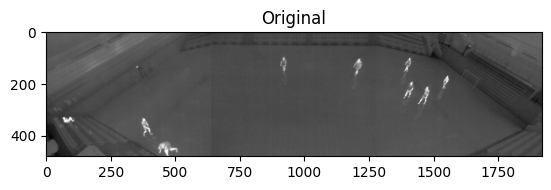

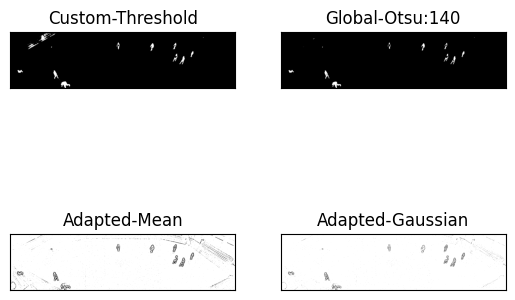

()


In [32]:
# Read the thermal image in grayscale
image = cv2.imread(image_directory)
image_gray = cv2.imread(image_directory, cv2.IMREAD_GRAYSCALE) # 그레이 스케일로  읽기

processed_image = preprocessing(image_gray)

rect = detection(image)

# Draw rectangles around the detected pedestrians
for (x, y, w, h) in rect:
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Display the original and two-tone images
cv2.imshow('Original Thermal Image', image)
# cv2.imshow('Two-Tone Image', processed_image)

cv2.waitKey(0)
cv2.destroyAllWindows()


In [8]:
def submission():
    with open(output_csv, 'w', newline='') as csvfile:
        fieldnames = ['image_id', 'x1', 'x2', 'y1', 'y2', 'conf']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        writer.writeheader()

        for filename in os.listdir(data_dir):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                image_path = os.path.join(data_dir, filename)
                x1, x2, y1, y2, conf = detection(image_path)
                
                # Assuming image_id is the filename without extension
                image_id, _ = os.path.splitext(filename)
                
                writer.writerow({
                    'image_id': image_id,
                    'x1': x1,
                    'x2': x2,
                    'y1': y1,
                    'y2': y2,
                    'conf': conf
                })

### Using SVM training method

In [ ]:
# Train SVM
annotation_file_path = 'annotations.csv'
samples=[]
labels = []
with open(annotation_file_path, 'r') as csv_file:
    # Create a CSV reader object
    csv_reader = csv.reader(csv_file)
    # Read and print each row
    for row in csv_reader:
        img = cv2.imread('data/'+row['ImageName'], cv2.IMREAD_GRAYSCALE)
        x1,x2,y1,y2 = row['X1'],row['X2'],row['Y1'],row['Y2']
        cropped_img = image[y1:y2, x1:x2]
        hist =  hog(img, orientations=9, pixels_per_cell=(6, 6),cells_per_block=(2, 2),block_norm='L1', visualise=False,transform_sqrt=False,feature_vector=True,normalise=None)

        data_entry = {
            'image_id': row['image_id'],
            'file_path': row['ImageName'],
            'class_label': row['Class'],
            'x1': row['X1'],
            'y1': row['Y1'],
            'x2': row['X2'],
            'y2': row['Y2']
        }

        samples.append(hist)
        labels.append(row['Class'])

samples = np.float32(samples)
labels = np.array(labels)

svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_RBF) # cv2.ml.SVM_LINEAR
# svm.setDegree(0.0)
svm.setGamma(5.383)
# svm.setCoef0(0.0)
svm.setC(2.67)
# svm.setNu(0.0)
# svm.setP(0.0)
# svm.setClassWeights(None)

# Train
svm.train(samples, cv2.ml.ROW_SAMPLE, labels)

In [33]:
from skimage.transform import pyramid_gaussian

In [ ]:
# Detect
min_wdw_sz = [64, 128]
step_size = [10,10]
orientations = 9
pixels_per_cell = [6,6]
cells_per_block = [2, 2]
visualize = False
normalize = True
threshold = 0.3

def sliding_window(image, window_size, step_size):
    '''
    This function returns a patch of the input 'image' of size 
    equal to 'window_size'. The first image returned top-left 
    co-ordinate (0, 0) and are increment in both x and y directions
    by the 'step_size' supplied.

    So, the input parameters are-
    image - Input image
    window_size - Size of Sliding Window 
    step_size - incremented Size of Window

    The function returns a tuple -
    (x, y, im_window)
    '''
    for y in range(0, image.shape[0], step_size[1]):
        for x in range(0, image.shape[1], step_size[0]):
            yield (x, y, image[y: y + window_size[1], x: x + window_size[0]])


def detector(filename):
    im = cv2.imread(filename)
    # im = cv2.resize(im, width = min(400, im.shape[1]))
    min_wdw_sz = (64, 128)
    step_size = (10, 10)
    downscale = 1.6

    #List to store the detections
    detections = []
    #The current scale of the image 
    scale = 0

    for im_scaled in pyramid_gaussian(im, downscale = downscale):
        #The list contains detections at the current scale
        if im_scaled.shape[0] < min_wdw_sz[1] or im_scaled.shape[1] < min_wdw_sz[0]:
            break
        for (x, y, im_window) in sliding_window(im_scaled, min_wdw_sz, step_size):
            if im_window.shape[0] != min_wdw_sz[1] or im_window.shape[1] != min_wdw_sz[0]:
                continue
            im_window = color.rgb2gray(im_window)
            fd =  hog(im_window, orientations=9, pixels_per_cell=(6, 6),cells_per_block=(2, 2),block_norm='L1', visualise=False,transform_sqrt=False,feature_vector=True,normalise=None)
            fd = fd.reshape(1, -1)
            pred = svm.predict(fd)    if os.path.isfile(file_path):

            if pred == 1:
                
                if svm.decision_function(fd) > 0.5:
                    detections.append((int(x * (downscale**scale)), int(y * (downscale**scale)), svm.decision_function(fd), int(min_wdw_sz[0] * (downscale**scale)),int(min_wdw_sz[1] * (downscale**scale))))
                 
        scale += 1

    clone = im.copy()

    rects = np.array([[x, y, x + w, y + h] for (x, y, _, w, h) in detections])
    sc = [score[0] for (x, y, score, w, h) in detections]
    print ("sc: ", sc)
    sc = np.array(sc)
    # pick = non_max_suppression(rects, probs = sc, overlapThresh = 0.3)
    #print ("shape, ", pick.shape)
   
    for (x_tl, y_tl, _, w, h) in detections:
        cv2.rectangle(im, (x_tl, y_tl), (x_tl + w, y_tl + h), (0, 255, 0), thickness = 2)
    # for(xA, yA, xB, yB) in pick:
    #     cv2.rectangle(clone, (xA, yA), (xB, yB), (0, 255, 0), 2)
    scale_percent=70
    w=clone.shape[1]
    h=clone.shape[0]

    # width = int(w * scale_percent / 100)
    # height = int(h * scale_percent / 100)
    # dim = (width, height)
    # resized = cv2.resize(clone, dim, interpolation=cv2.INTER_AREA)
    # plt.axis("off")
    # plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    # plt.title("Raw Detection before NMS")
    # plt.show()

    # plt.axis("off")
    # plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
    # plt.title("Final Detections after applying NMS")
    # plt.show()

def test_folder(foldername):

    filenames = glob.glob(os.path.join(foldername, '*'))
    for filename in filenames:
        detector(filename)